# Exploratory Data Analysis

This notebook provides a starter analysis of financial data, including account states, transactions, and payments. It demonstrates how to load the input data and plots distributions for the population as well as time series for individual agents. This notebook does not do EDA on the labels. That is left up to you.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import (
    plot_merchant_type_distribution,
    plot_transaction_amount_distribution,
    plot_event_distribution,
    plot_behavior_over_time,
    display_table_info
)

In [2]:
# Load data
account_state_log = pd.read_csv('../synthcc_train_set/account_state_log.csv')
transactions_log = pd.read_csv('../synthcc_train_set/transactions_log.csv', parse_dates=['timestamp'])
payments_log = pd.read_csv('../synthcc_train_set/payments_log.csv', parse_dates=['timestamp'])

In [3]:
account_state_log.head()

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,839,367.017294,0.367,0.191914,0.05,0,2023-01-01
1,179,638.371473,0.638,0.191758,0.05,0,2023-01-01
2,645,652.219191,0.326,0.235719,0.05,0,2023-01-01
3,170,777.674485,0.078,0.234455,0.05,0,2023-01-01
4,152,634.101608,0.317,0.247455,0.05,0,2023-01-01


In [4]:
# Display information for each table
display_table_info(account_state_log, 'account_state_log')
display_table_info(transactions_log, 'transactions_log')
display_table_info(payments_log, 'payments_log')

Schema and attributes of account_state_log:
   agent_id  credit_balance  credit_utilization  interest_rate  \
0       839      367.017294               0.367       0.191914   
1       179      638.371473               0.638       0.191758   
2       645      652.219191               0.326       0.235719   
3       170      777.674485               0.078       0.234455   
4       152      634.101608               0.317       0.247455   

   min_payment_factor  current_missed_payments   timestamp  
0                0.05                        0  2023-01-01  
1                0.05                        0  2023-01-01  
2                0.05                        0  2023-01-01  
3                0.05                        0  2023-01-01  
4                0.05                        0  2023-01-01   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373225 entries, 0 to 373224
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------               

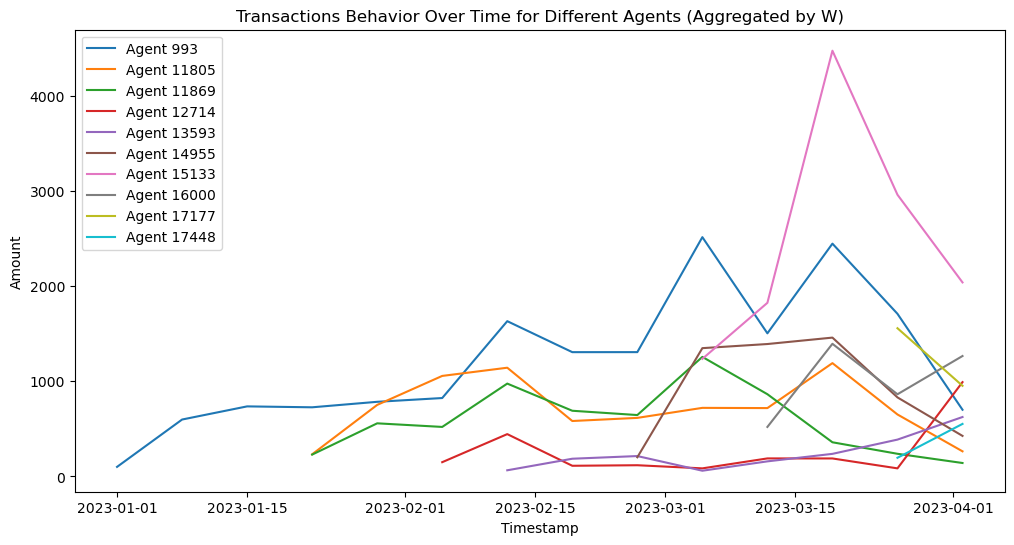

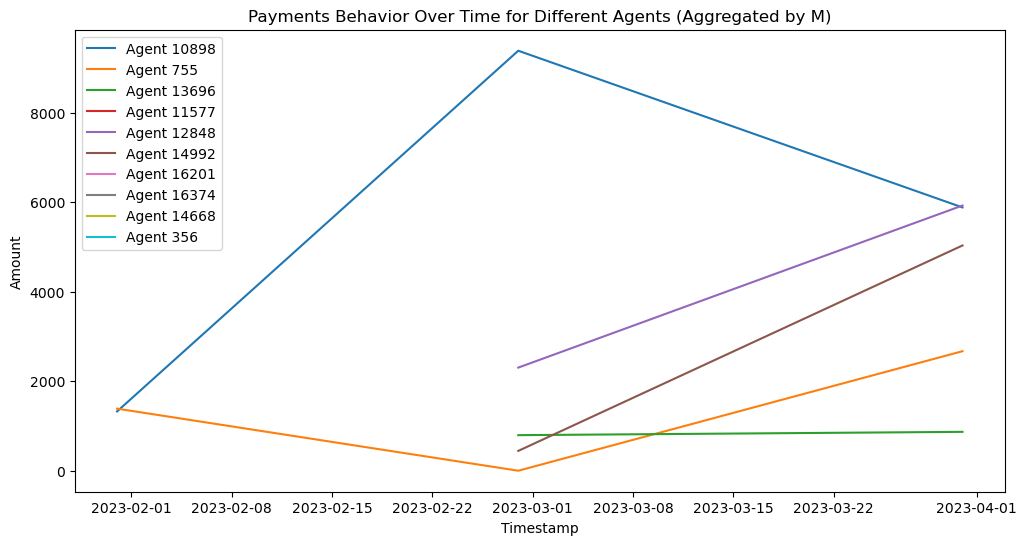

In [5]:
plot_behavior_over_time(transactions_log, sample_size=10, period='W', data_type='transactions')  # For transactions
plot_behavior_over_time(payments_log, sample_size=10, period='M', data_type='payments')  # For payments

In [6]:
import pandas as pd

account_state_log['timestamp'] = pd.to_datetime(account_state_log['timestamp']).dt.date
payments_log['timestamp'] = pd.to_datetime(payments_log['timestamp']).dt.date
transactions_log['timestamp'] = pd.to_datetime(transactions_log['timestamp']).dt.date

# Sort all dataframes by timestamp
account_state_log = account_state_log.sort_values(['agent_id', 'timestamp'])
payments_log = payments_log.sort_values(['agent_id', 'timestamp'])
transactions_log = transactions_log.sort_values(['agent_id', 'timestamp'])

# Create transaction aggregations by date and agent
transaction_features = (
    transactions_log
    .groupby(['agent_id', 'timestamp', 'merchant_category'])
    .agg({
        'amount': ['count', 'sum']  # Count of transactions and sum of amounts per category
    })
    .reset_index()
)
transaction_features.columns = ['agent_id', 'timestamp', 'merchant_category', 
                                'category_transaction_count', 'category_amount_sum']


# Pivot the merchant categories to create separate columns
category_features = (
    transaction_features
    .pivot_table(
        index=['agent_id', 'timestamp'],
        columns='merchant_category',
        values=['category_transaction_count', 'category_amount_sum'],
        fill_value=0
    )
    .reset_index()
)

# Flatten column names
category_features.columns = [
    f"{col[0]}_{col[1]}".replace(' ', '_').lower() 
    if isinstance(col, tuple) else col 
    for col in category_features.columns
]

# Create status aggregations
status_features = (
    transactions_log
    .groupby(['agent_id', 'timestamp'])
    .agg({
        'status': lambda x: (x == 'approved').sum(),  # Count of approved
    })
    .rename(columns={'status': 'approved_count'})
    .reset_index()
)


# Add declined count
status_features['declined_count'] = (
    transactions_log
    .groupby(['agent_id', 'timestamp'])
    .size()
    .reset_index(name='total_count')
    ['total_count'] - status_features['approved_count']
)

daily_payments = payments_log.groupby(['agent_id', 'timestamp'])['amount'].sum().reset_index()




In [7]:
daily_payments

,agent_id,timestamp,amount
0,0,2023-02-20,2925.82
1,0,2023-03-27,2953.11
2,3,2023-01-16,897.64
3,3,2023-01-19,848.27
4,3,2023-03-02,925.06
...,...,...,...
20386,18045,2023-03-31,566.98
20387,18054,2023-03-31,740.36
20388,18060,2023-03-31,376.65
20389,18072,2023-03-31,352.49


In [8]:
category_features

,agent_id_,timestamp_,category_amount_sum_agricultural,category_amount_sum_business,category_amount_sum_clothing,category_amount_sum_contractor,category_amount_sum_misc,category_amount_sum_professional,category_amount_sum_retail,category_amount_sum_transportation,category_amount_sum_utility,category_transaction_count_agricultural,category_transaction_count_business,category_transaction_count_clothing,category_transaction_count_contractor,category_transaction_count_misc,category_transaction_count_professional,category_transaction_count_retail,category_transaction_count_transportation,category_transaction_count_utility
0,0,2023-01-01,0.0,0.00,0.0,0.0,0.00,81.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,2023-01-02,0.0,0.00,0.0,0.0,114.95,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,2023-01-04,0.0,0.00,0.0,0.0,114.95,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,2023-01-05,0.0,0.00,0.0,0.0,0.00,81.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,2023-01-07,0.0,0.00,0.0,0.0,114.95,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345239,18094,2023-03-31,0.0,0.00,0.0,0.0,8.64,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
345240,18095,2023-03-31,0.0,281.63,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345241,18097,2023-03-31,0.0,281.63,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345242,18098,2023-03-31,0.0,281.63,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
status_features

,agent_id,timestamp,approved_count,declined_count
0,0,2023-01-01,1,0
1,0,2023-01-02,1,0
2,0,2023-01-04,1,0
3,0,2023-01-05,1,0
4,0,2023-01-07,1,0
...,...,...,...,...
345239,18094,2023-03-31,1,0
345240,18095,2023-03-31,1,0
345241,18097,2023-03-31,1,0
345242,18098,2023-03-31,1,0


In [10]:
labels_log = pd.read_csv("../synthcc_train_set/labels.csv")

In [11]:
category_features = category_features.rename(
    columns={
        'agent_id_': 'agent_id',
        'timestamp_': 'timestamp'
    }
)


In [12]:
# Merge daily_payments with category_features on agent_id and timestamp
merged_data = pd.merge(
    status_features, 
    category_features, 
    on=['agent_id', 'timestamp'], 
    how='inner'
)

# Perform a left join with status_features
merged_data = pd.merge(
    merged_data, 
    daily_payments, 
    on=['agent_id', 'timestamp'], 
    how='left'
)

# Fill missing values in status_features with 0
merged_data['approved_count'] = merged_data['approved_count'].fillna(0).astype(int)
merged_data['declined_count'] = merged_data['declined_count'].fillna(0).astype(int)
merged_data['amount'] = merged_data['amount'].fillna(0).astype(int)

# The resulting dataframe `merged_data` now contains all the desired information

In [13]:
merged_data.columns

Index(['agent_id', 'timestamp', 'approved_count', 'declined_count',
       'category_amount_sum_agricultural', 'category_amount_sum_business',
       'category_amount_sum_clothing', 'category_amount_sum_contractor',
       'category_amount_sum_misc', 'category_amount_sum_professional',
       'category_amount_sum_retail', 'category_amount_sum_transportation',
       'category_amount_sum_utility',
       'category_transaction_count_agricultural',
       'category_transaction_count_business',
       'category_transaction_count_clothing',
       'category_transaction_count_contractor',
       'category_transaction_count_misc',
       'category_transaction_count_professional',
       'category_transaction_count_retail',
       'category_transaction_count_transportation',
       'category_transaction_count_utility', 'amount'],
      dtype='object')

In [14]:
merged_data= merged_data.rename(
    columns={
        'amount':'daily_spent'
    }
)

In [15]:
account_state_log['timestamp'] = pd.to_datetime(account_state_log['timestamp']).dt.date
payments_log['timestamp'] = pd.to_datetime(payments_log['timestamp']).dt.date

# Sort all dataframes by timestamp
account_state_log = account_state_log.sort_values(['agent_id', 'timestamp'])
payments_log = payments_log.sort_values(['agent_id', 'timestamp'])

# Resample credit data to daily frequency and forward fill
credit_features = account_state_log.pivot_table(
    index=['timestamp', 'agent_id'],
    values=['credit_balance', 'credit_utilization', 'interest_rate', 
            'min_payment_factor', 'current_missed_payments']
).reset_index()

# Calculate daily payment amounts
daily_payments = payments_log.groupby(['agent_id', 'timestamp'])['amount'].sum().reset_index()

# Merge credit features with payments
features = pd.merge(account_state_log, daily_payments, 
                    on=['agent_id', 'timestamp'], how='left')
features['amount'] = features['amount'].fillna(0)

In [16]:
# Convert dates to datetime if needed
features['timestamp'] = pd.to_datetime(features['timestamp'])
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# Merge the dataframes
result = pd.merge(
    features,
    merged_data,
    on=['agent_id', 'timestamp'],
    how='inner',
    suffixes=('_features', '_merged')
)

print(f"Original Features Shape: {features.shape}")
print(f"Original Merged Data Shape: {merged_data.shape}")
print(f"Final Merged Shape: {result.shape}")

Original Features Shape: (373225, 8)
Original Merged Data Shape: (345244, 23)
Final Merged Shape: (345244, 29)


In [17]:
result

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp,amount,approved_count,declined_count,...,category_transaction_count_agricultural,category_transaction_count_business,category_transaction_count_clothing,category_transaction_count_contractor,category_transaction_count_misc,category_transaction_count_professional,category_transaction_count_retail,category_transaction_count_transportation,category_transaction_count_utility,daily_spent
0,0,631.101415,0.126,0.209866,0.05,0,2023-01-01,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,0,746.051415,0.149,0.209866,0.05,0,2023-01-02,0.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0,861.001415,0.172,0.209866,0.05,0,2023-01-04,0.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,0,942.431415,0.188,0.209866,0.05,0,2023-01-05,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0,1057.381415,0.211,0.209866,0.05,0,2023-01-07,0.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345239,18094,632.923620,0.316,0.215700,0.05,0,2023-03-31,0.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
345240,18095,847.473215,0.282,0.156766,0.05,0,2023-03-31,0.0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
345241,18097,919.299013,0.184,0.167936,0.05,0,2023-03-31,0.0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
345242,18098,692.018413,0.138,0.230177,0.05,0,2023-03-31,0.0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
result.columns

Index(['agent_id', 'credit_balance', 'credit_utilization', 'interest_rate',
       'min_payment_factor', 'current_missed_payments', 'timestamp', 'amount',
       'approved_count', 'declined_count', 'category_amount_sum_agricultural',
       'category_amount_sum_business', 'category_amount_sum_clothing',
       'category_amount_sum_contractor', 'category_amount_sum_misc',
       'category_amount_sum_professional', 'category_amount_sum_retail',
       'category_amount_sum_transportation', 'category_amount_sum_utility',
       'category_transaction_count_agricultural',
       'category_transaction_count_business',
       'category_transaction_count_clothing',
       'category_transaction_count_contractor',
       'category_transaction_count_misc',
       'category_transaction_count_professional',
       'category_transaction_count_retail',
       'category_transaction_count_transportation',
       'category_transaction_count_utility', 'daily_spent'],
      dtype='object')

In [19]:
result["timestamp"]

0        2023-01-01
1        2023-01-02
2        2023-01-04
3        2023-01-05
4        2023-01-07
            ...    
345239   2023-03-31
345240   2023-03-31
345241   2023-03-31
345242   2023-03-31
345243   2023-03-31
Name: timestamp, Length: 345244, dtype: datetime64[ns]

In [20]:
labels_log.columns

Index(['agent_id', 'charge_off_within_3_months', 'charge_off_within_6_months',
       'charge_off_within_9_months', 'charge_off_within_12_months'],
      dtype='object')

In [21]:
print(result['agent_id'].dtype)
print(labels_log['agent_id'].dtype)

int64
int64


In [22]:
merged_data = pd.merge(result, labels_log, on='agent_id', how='left')

In [23]:
merged_data.shape

(345244, 33)

In [24]:
merged_data.columns

Index(['agent_id', 'credit_balance', 'credit_utilization', 'interest_rate',
       'min_payment_factor', 'current_missed_payments', 'timestamp', 'amount',
       'approved_count', 'declined_count', 'category_amount_sum_agricultural',
       'category_amount_sum_business', 'category_amount_sum_clothing',
       'category_amount_sum_contractor', 'category_amount_sum_misc',
       'category_amount_sum_professional', 'category_amount_sum_retail',
       'category_amount_sum_transportation', 'category_amount_sum_utility',
       'category_transaction_count_agricultural',
       'category_transaction_count_business',
       'category_transaction_count_clothing',
       'category_transaction_count_contractor',
       'category_transaction_count_misc',
       'category_transaction_count_professional',
       'category_transaction_count_retail',
       'category_transaction_count_transportation',
       'category_transaction_count_utility', 'daily_spent',
       'charge_off_within_3_months', 'c

In [25]:
aggregated_data=merged_data

In [26]:
!pip install xgboost


Training model for charge_off_within_3_months...

Training model for charge_off_within_6_months...


/Users/stuti/miniconda3/envs/stub-env-synthcc/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/stuti/miniconda3/envs/stub-env-synthcc/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training model for charge_off_within_9_months...

Training model for charge_off_within_12_months...


/Users/stuti/miniconda3/envs/stub-env-synthcc/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/stuti/miniconda3/envs/stub-env-synthcc/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


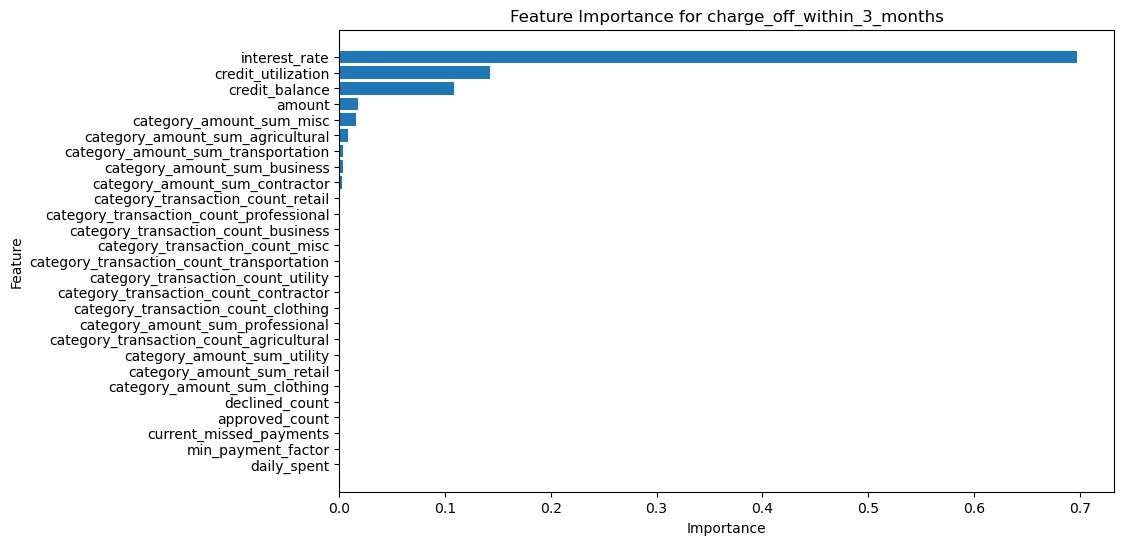

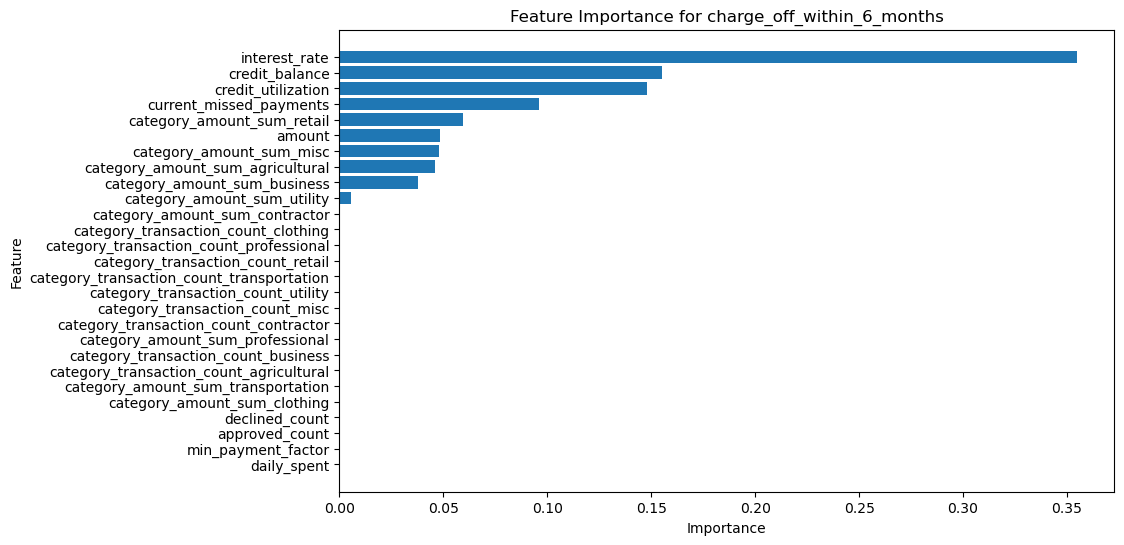

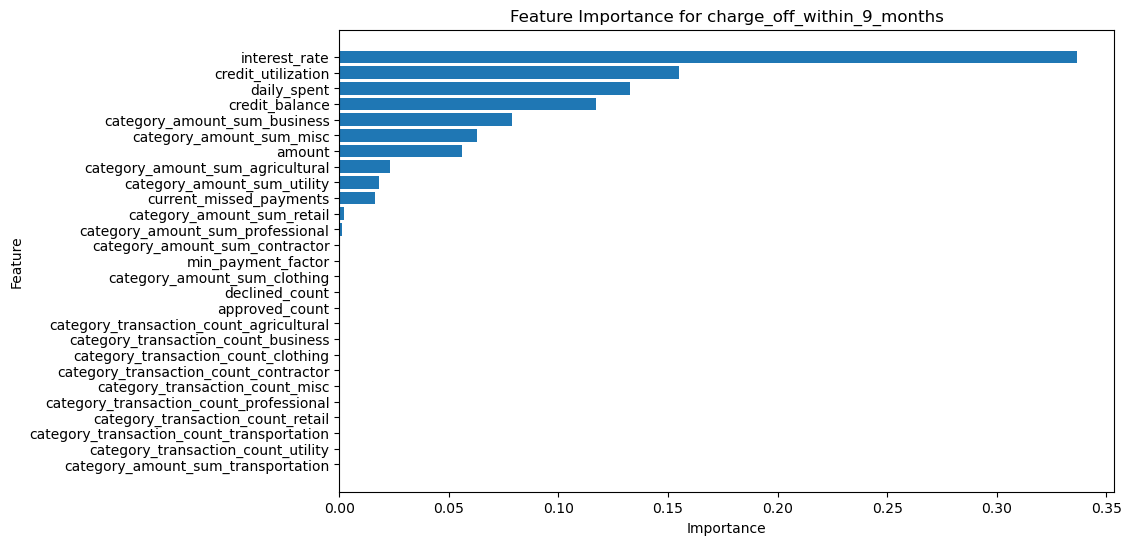

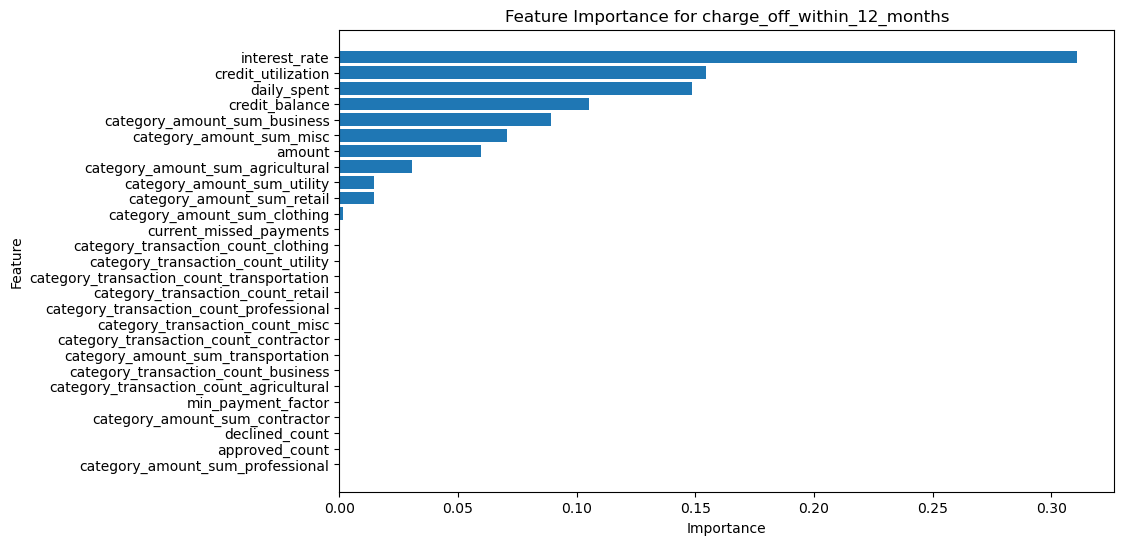

In [27]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define features and targets
features = [col for col in aggregated_data.columns if col not in 
            ['agent_id', 'timestamp', 
             'charge_off_within_3_months', 
             'charge_off_within_6_months', 
             'charge_off_within_9_months', 
             'charge_off_within_12_months']]

targets = ['charge_off_within_3_months', 
           'charge_off_within_6_months', 
           'charge_off_within_9_months', 
           'charge_off_within_12_months']

# Store feature importances for each target
feature_importance_results = {}

for target in targets:
    print(f"\nTraining model for {target}...")
    
    X = aggregated_data[features]
    y = aggregated_data[target]
    
    # Time-based split
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Skip folds with single class
        if len(y_train.unique()) < 2 or len(y_test.unique()) < 2:
            print("Skipping fold due to single class in train or test data.")
            continue
        
        # Train the XGBoost model
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            use_label_encoder=False,
            random_state=42,
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            reg_alpha=10,
            reg_lambda=10
        )
        model.fit(X_train, y_train)
        
        # Collect feature importances
        feature_importance = model.feature_importances_
        feature_importance_results[target] = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)
        
        break  # Use only the first fold for feature importance

# Plot feature importance for each target
for target, importance_df in feature_importance_results.items():
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
    plt.title(f"Feature Importance for {target}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis for readability
    plt.show()

In [28]:
feature_importance_results[target]

,Feature,Importance
2,interest_rate,0.310918
1,credit_utilization,0.154684
26,daily_spent,0.148395
0,credit_balance,0.105226
9,category_amount_sum_business,0.089017
12,category_amount_sum_misc,0.070560
5,amount,0.059885
8,category_amount_sum_agricultural,0.030524
16,category_amount_sum_utility,0.014653
14,category_amount_sum_retail,0.014572


In [29]:
!pip install tensorflow

In [31]:
high_importance_features= feature_importance_results[target].Feature

In [32]:
high_importance_features=high_importance_features[:9]

In [38]:
from sklearn.model_selection import train_test_split# Create a multi-class target
def create_multiclass_target(row):
    if row['charge_off_within_3_months'] == 1:
        return 1
    elif row['charge_off_within_6_months'] == 1:
        return 2
    elif row['charge_off_within_9_months'] == 1:
        return 3
    elif row['charge_off_within_12_months'] == 1:
        return 4
    else:
        return 0

aggregated_data['multi_class_target'] = aggregated_data.apply(create_multiclass_target, axis=1)

# Features and target
X = aggregated_data[high_importance_features]
y = aggregated_data['multi_class_target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a multi-class classifier
from xgboost import XGBClassifier
model = XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
model.save_model("xgboost_model.json")
print("Model saved as xgboost_model.json")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Model saved as xgboost_model.json
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66923
           1       0.95      0.58      0.72       175
           2       0.92      0.30      0.45       649
           3       0.86      0.25      0.39       690
           4       0.87      0.25      0.38       612

    accuracy                           0.98     69049
   macro avg       0.91      0.48      0.59     69049
weighted avg       0.98      0.98      0.97     69049



In [28]:
!pip install scikit-learn